## Refining the spin direction

This notebook provides examples of two methods for refining the spin direction: 
   1. Updating the basis vector(s) and calling the makeSpins() function, which is a very general method and will work for magnetic structures of arbitrary complexity;
   2. Storing the locations of the "up" spins and "down" spins and updating them without calling makeSpins(), which is faster but best suited only for simple collinear magnetic structures.

In [2]:
### Import everything we need
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from diffpy.Structure import loadStructure
from diffpy.magpdf import *

import time # we will be doing some speed testing

%matplotlib notebook

In [3]:
### Create the structure from our cif file, update the lattice params
structureFile = "MnO_R-3m.cif"
mnostructure = loadStructure(structureFile)
lat=mnostructure.lattice
lat.a,lat.b,lat.c=3.1505626,3.1505626,7.5936979
print mnostructure

lattice=Lattice(a=3.15056, b=3.15056, c=7.5937, alpha=90, beta=90, gamma=120)
Mn   0.000000 0.000000 0.000000 1.0000
Mn   0.333333 0.666667 0.666667 1.0000
Mn   0.666667 0.333333 0.333333 1.0000
O    0.000000 0.000000 0.500000 1.0000
O    0.333333 0.666667 0.166667 1.0000
O    0.666667 0.333333 0.833333 1.0000


In [4]:
### Set up the magSpecies
mn2p=magSpecies(struc=mnostructure,label='Mn2+')
mn2p.magIdxs=[0,1,2]
mn2p.kvecs=np.array([[0,0,1.5]])
mn2p.ffparamkey='Mn2'

# start with a randomly oriented spin basis vector
theta0=np.arccos(np.random.uniform(-1,1))
phi0=np.random.uniform(-np.pi,np.pi)
mn2p.basisvecs=2.5*np.array([[np.sin(theta0)*np.cos(phi0),
                              np.sin(theta0)*np.sin(phi0),np.cos(theta0)]])

In [5]:
### Create and prep the magStructure
magstruc=magStructure()
magstruc.loadSpecies(mn2p)
magstruc.makeAll()

Running checks for Mn2+ magSpecies object...

All magSpecies() checks passed. No obvious problems found.

Running checks for  magStructure object...

All magStructure checks passed. No obvious problems found.
Running checks for Mn2+ magSpecies object...

All magSpecies() checks passed. No obvious problems found.

Running checks for  magStructure object...

All magStructure checks passed. No obvious problems found.


/home/ben/anaconda/envs/magpdfdev/lib/python2.7/site-packages/diffpy.Structure-1.3.2-py2.7.egg/diffpy/Structure/lattice.py:125: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if [a, b, c, alpha, beta, gamma, base] == 7*[None]:


In [6]:
### Set up the mPDF calculator
mc=mPDFcalculator(magstruc=magstruc,gaussPeakWidth=0.2)

In [7]:
### Load the data
PDFfitFile='MnOfit_PDFgui.fgr'
rexp,Drexp=getDiffData([PDFfitFile])
mc.rmin=rexp.min()
mc.rmax=rexp.max()

### Method 1: Update the basis vector directly and call makeSpins()

Refined parameters:  [  3.73040113e+00   1.21317084e+00   1.57079371e+00   5.91209473e+03]
Duration of refinement:  3.48694086075
Refined spin:  [  2.31920135e+00  -9.33437256e-01   6.53025690e-06]


<IPython.core.display.Javascript object>


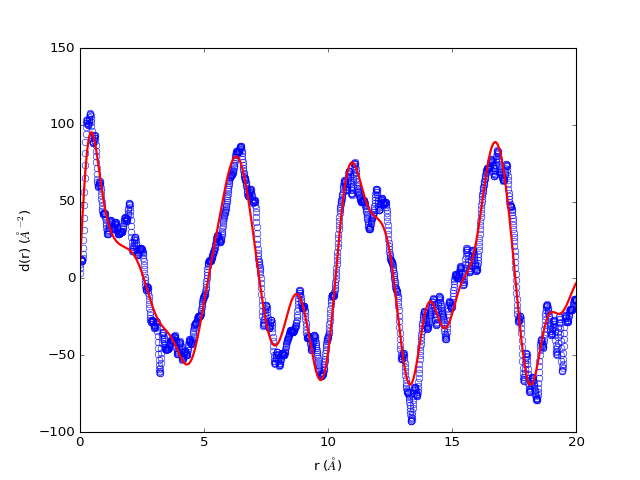

In [8]:
# Do the refinement
def residual1(p,yexp):
    mc.paraScale,mc.ordScale,theta,phi=p
    mn2p.basisvecs=2.5*np.array([[np.sin(theta)*np.cos(phi),
                                  np.sin(theta)*np.sin(phi),np.cos(theta)]])
    magstruc.makeSpins()
    return yexp-mc.calc(both=True)[2]

p0=[5.0,3.0,theta0,phi0]

start=time.time()
pOpt=leastsq(residual1,p0,args=(Drexp))
end=time.time()

print 'Refined parameters: ',pOpt[0]
print 'Duration of refinement: ',end-start
thetaF,phiF=pOpt[0][2],pOpt[0][3]
Sfinal=2.5*np.array([np.sin(thetaF)*np.cos(phiF),
                                  np.sin(thetaF)*np.sin(phiF),np.cos(thetaF)])
print 'Refined spin: ',Sfinal

fit=mc.calc(both=True)[2]

# Plot the results
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(rexp,Drexp,marker='o',mfc='none',mec='b',linestyle='none')
ax.plot(rexp,fit,'r-',lw=2)
ax.set_xlim(xmin=mc.rmin,xmax=mc.rmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('d(r) ($\AA^{-2}$)')

plt.show()

### Method 2: Store the locations of the up and down spins and use these to update

Refined parameters:  [  3.73040113e+00   1.21317084e+00   1.57079371e+00   5.91209473e+03]
Duration of refinement:  2.75030899048
Refined spin:  [  2.31920135e+00  -9.33437256e-01   6.53025690e-06]


<IPython.core.display.Javascript object>


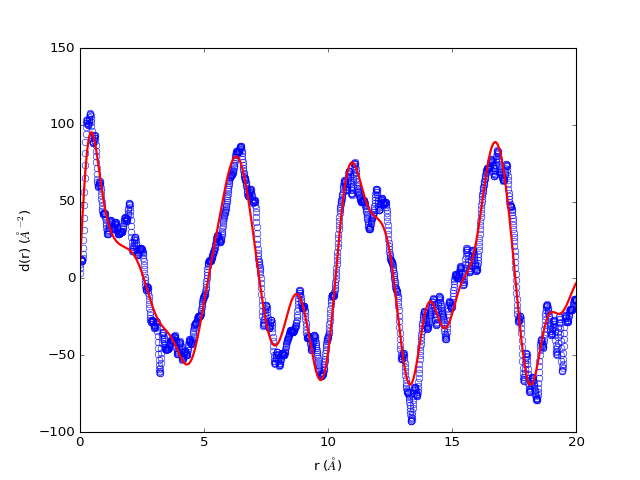

In [9]:
### Reset the magnetic structure to how it was originally
mn2p.basisvecs=2.5*np.array([[np.sin(theta0)*np.cos(phi0),
                              np.sin(theta0)*np.sin(phi0),np.cos(theta0)]])
magstruc.makeSpins()

### Find the locations of the up and down spins (we are creating boolean masks)
upSpins=np.all(magstruc.spins==mn2p.basisvecs[0],axis=1)
downSpins=np.all(magstruc.spins==-1.0*mn2p.basisvecs[0],axis=1)

### Modify the residual function
def residual2(p,yexp):
    mc.paraScale,mc.ordScale,theta,phi=p
    Svec=2.5*np.array([np.sin(theta)*np.cos(phi),
                                  np.sin(theta)*np.sin(phi),np.cos(theta)])
    magstruc.spins[upSpins]=Svec
    magstruc.spins[downSpins]=-Svec
    return yexp-mc.calc(both=True)[2]

p0=[5.0,3.0,theta0,phi0]

start=time.time()
pOpt=leastsq(residual2,p0,args=(Drexp))
end=time.time()

print 'Refined parameters: ',pOpt[0]
print 'Duration of refinement: ',end-start
thetaF,phiF=pOpt[0][2],pOpt[0][3]
Sfinal=2.5*np.array([np.sin(thetaF)*np.cos(phiF),
                                  np.sin(thetaF)*np.sin(phiF),np.cos(thetaF)])
print 'Refined spin: ',Sfinal

### Update the magnetic structure with the refined spin
mn2p.basisvecs=np.array([Sfinal])
magstruc.makeSpins()
fit=mc.calc(both=True)[2]

### Plot the results
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(rexp,Drexp,marker='o',mfc='none',mec='b',linestyle='none')
ax.plot(rexp,fit,'r-',lw=2)
ax.set_xlim(xmin=mc.rmin,xmax=mc.rmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('d(r) ($\AA^{-2}$)')

plt.show()

In [9]:
plt.close('all')